In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D,Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ================================
# 1. CARGA Y PROCESAMIENTO DEL DATASET
# ================================

dataset_path = r"/content/drive/MyDrive/UCMerced_LandUse/Images"
nclases = 21
img_size = (256, 256)

X = []
y = []
clase_dict = {}

for idx, clase in enumerate(sorted(os.listdir(dataset_path))):
    clase_path = os.path.join(dataset_path, clase)
    if os.path.isdir(clase_path):
        clase_dict[idx] = clase
        for img_name in os.listdir(clase_path):
            img_path = os.path.join(clase_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img)
                X.append(img_array)
                y.append(idx)
            except Exception as e:
                print(f"Error cargando imagen {img_path}: {e}")

X = np.array(X).astype('float32') / 255.0
y = np.array(y)

# División 80-10-10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# One-hot encoding
y_train_cat = to_categorical(y_train, nclases)
y_val_cat = to_categorical(y_val, nclases)
y_test_cat = to_categorical(y_test, nclases)

print(f"Training data shape: {X_train.shape}, {y_train_cat.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val_cat.shape}")
print(f"Test data shape: {X_test.shape}, {y_test_cat.shape}")

Training data shape: (1680, 256, 256, 3), (1680, 21)
Validation data shape: (210, 256, 256, 3), (210, 21)
Test data shape: (210, 256, 256, 3), (210, 21)


In [4]:
# ================================
# 2. DEFINICIÓN DEL MODELO CNN
# ================================

cnn = Sequential([
    # Bloque 1
    Conv2D(64, (3, 3), activation='relu', padding='same',
           input_shape=(256, 256, 3),
           kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Bloque 2
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Bloque 3
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Global Average Pooling en vez de Flatten
    GlobalAveragePooling2D(),

    # Capas densas
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(21, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# ================================
# 3. ENTRENAMIENTO DEL MODELO
# ================================

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=12,
    min_lr=0.00001
)

history = cnn.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_val, y_val_cat),
    epochs=500,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.1477 - loss: 4.0187 - val_accuracy: 0.0476 - val_loss: 4.8477 - learning_rate: 0.0010
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 649ms/step - accuracy: 0.3278 - loss: 3.0946 - val_accuracy: 0.0476 - val_loss: 6.1749 - learning_rate: 0.0010
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 633ms/step - accuracy: 0.3781 - loss: 2.8180 - val_accuracy: 0.0571 - val_loss: 6.1133 - learning_rate: 0.0010
Epoch 4/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 668ms/step - accuracy: 0.3969 - loss: 2.6611 - val_accuracy: 0.0762 - val_loss: 6.5290 - learning_rate: 0.0010
Epoch 5/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - accuracy: 0.4297 - loss: 2.5497 - val_accuracy: 0.0619 - val_loss: 6.8150 - learning_rate: 0.0010
Epoch 6/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 652ms/step - accuracy: 0.4788 - loss: 2.3458 - val_accuracy: 0.0762 - val_loss: 5.9837 - learning_rate: 0.0010
Epoch 7/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 634ms/step - accuracy: 0.5112 - los

In [5]:
# ================================
# 4. EVALUACIÓN DEL MODELO
# ================================

train_loss, train_accuracy = cnn.evaluate(X_train, y_train_cat)
val_loss, val_accuracy = cnn.evaluate(X_val, y_val_cat)
test_loss, test_accuracy = cnn.evaluate(X_test, y_test_cat)

print(f"\nTraining Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 1.0000 - loss: 0.2163
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9568 - loss: 0.3056
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9388 - loss: 0.4536

Training Accuracy: 100.00%
Validation Accuracy: 95.71%
Test Accuracy: 94.29%


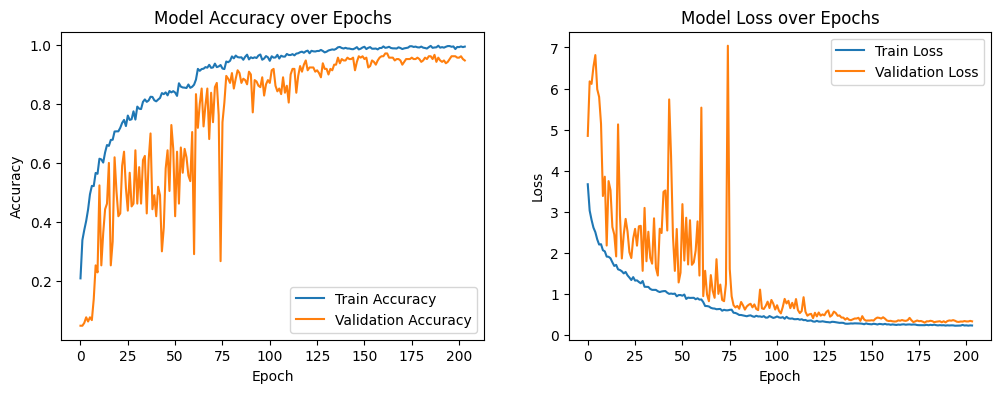

In [6]:
# ================================
# 5. GRÁFICAS DE ENTRENAMIENTO
# ================================

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step


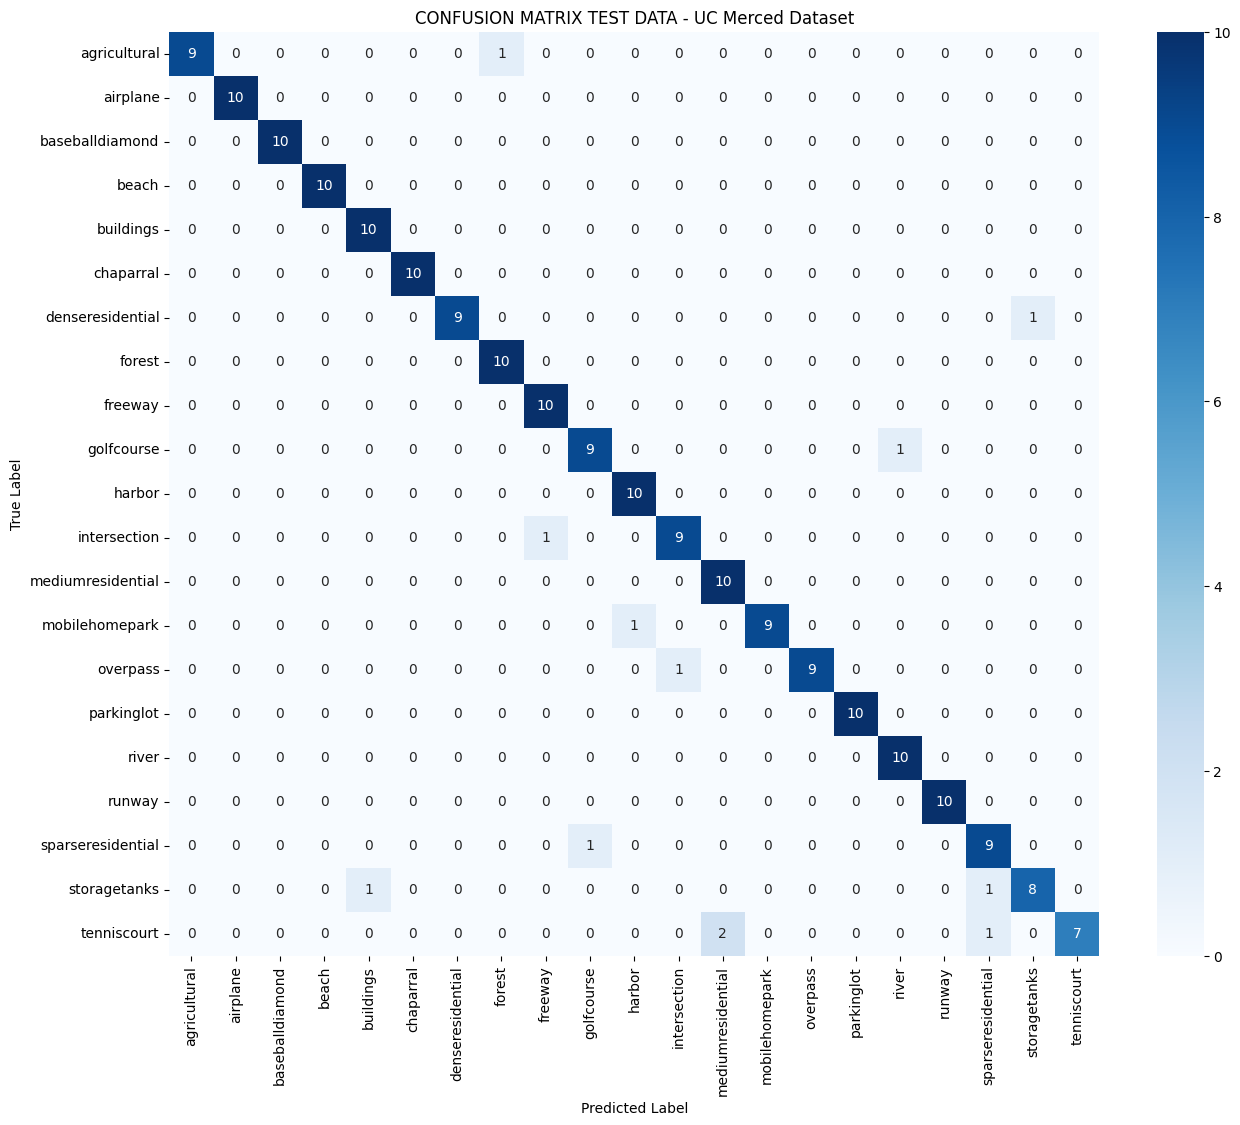

In [7]:
# ================================
# 6. MATRIZ DE CONFUSIÓN DATOS DE TESTEO
# ================================

y_pred = np.argmax(cnn.predict(X_test), axis=-1)
y_true = np.argmax(y_test_cat, axis=-1)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(clase_dict.values()),
            yticklabels=list(clase_dict.values()))
plt.title('CONFUSION MATRIX TEST DATA - UC Merced Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


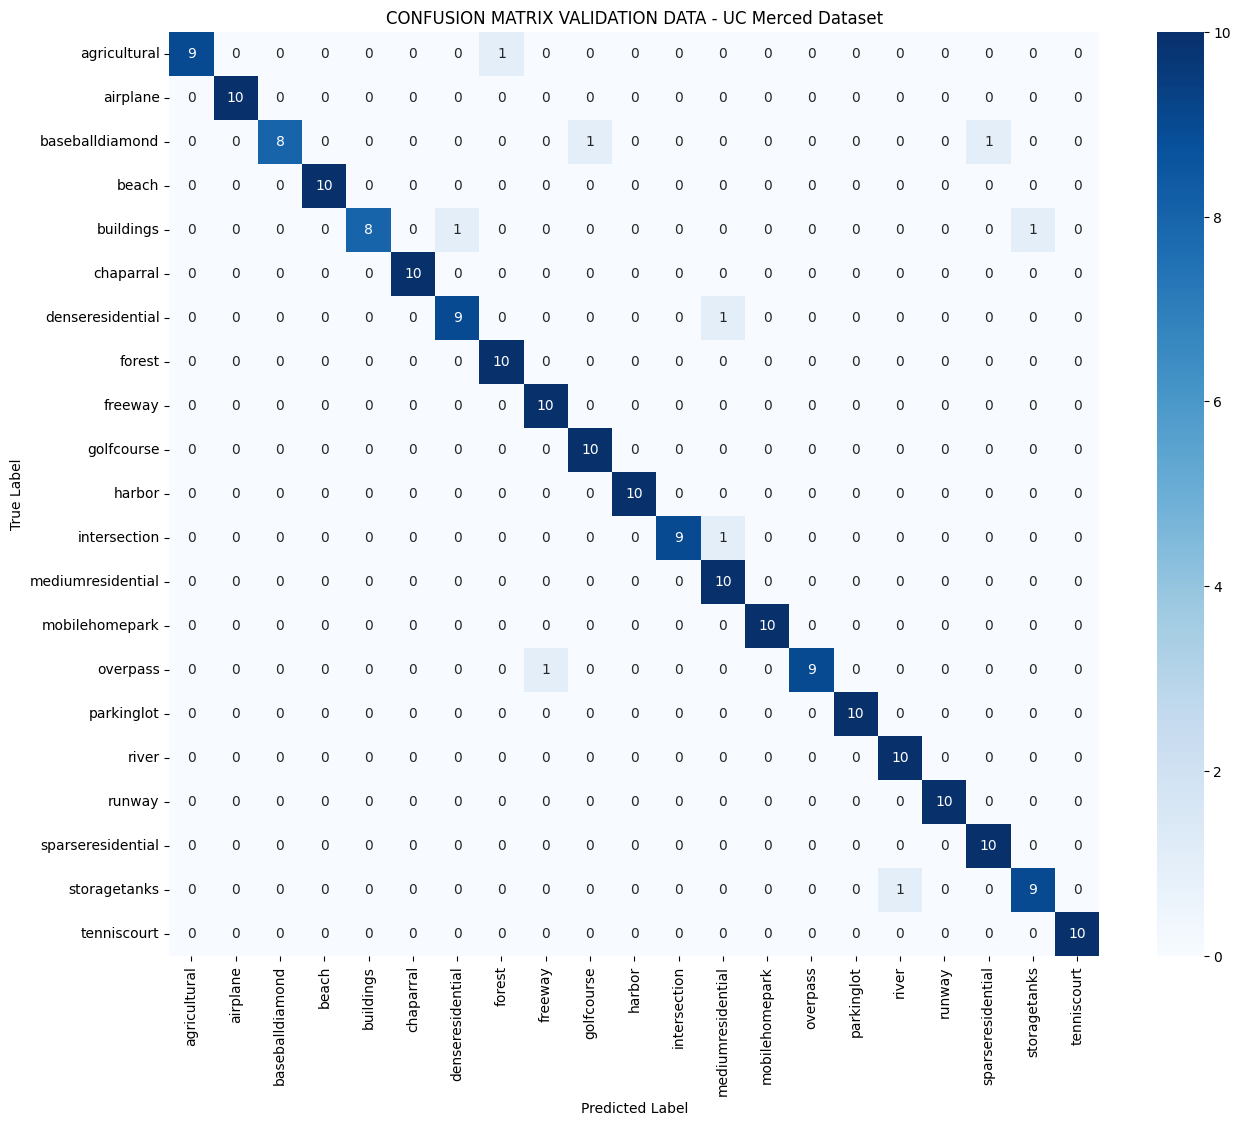

In [8]:
# ================================
# 7. MATRIZ DE CONFUSIÓN DATOS DE VALIDACIÓN
# ================================

y_pred = np.argmax(cnn.predict(X_val), axis=-1)
y_true = np.argmax(y_val_cat, axis=-1)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(clase_dict.values()),
            yticklabels=list(clase_dict.values()))
plt.title('CONFUSION MATRIX VALIDATION DATA - UC Merced Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step


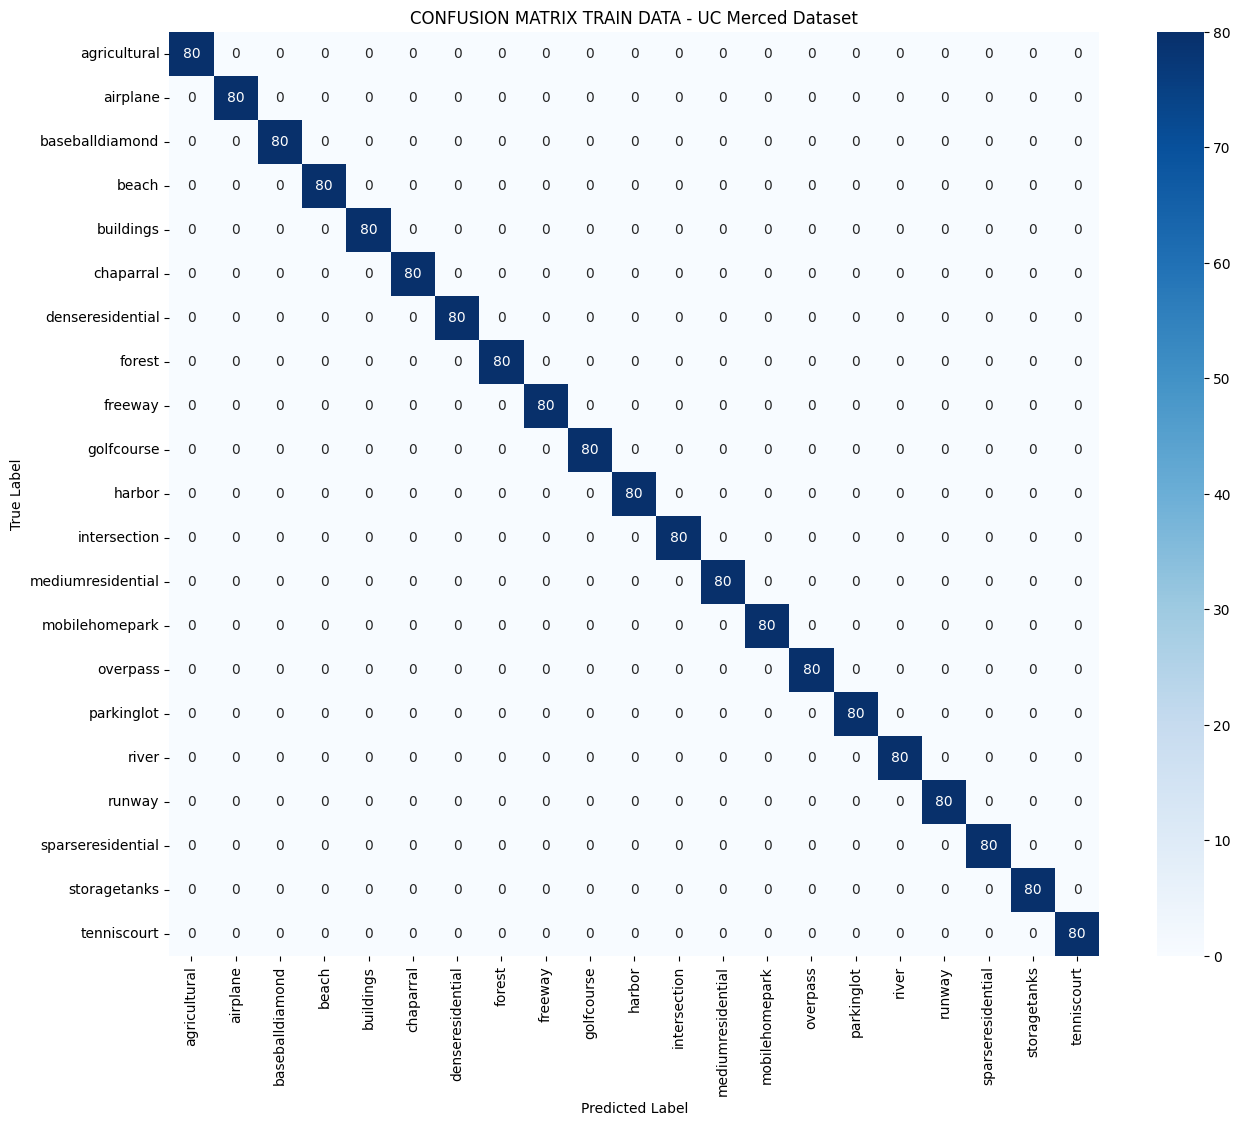

In [9]:
# ================================
# 7. MATRIZ DE CONFUSIÓN DATOS DE ENTRENAMIENTO
# ================================

y_pred = np.argmax(cnn.predict(X_train), axis=-1)
y_true = np.argmax(y_train_cat, axis=-1)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(clase_dict.values()),
            yticklabels=list(clase_dict.values()))
plt.title('CONFUSION MATRIX TRAIN DATA - UC Merced Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [10]:
# ================================
# 7. PRECISIÓN POR CLASE
# ================================

print("\nAccuracy por clase:")
for i in range(nclases):
    mask = (y_true == i)
    if np.sum(mask) > 0:
        acc = accuracy_score(y_true[mask], y_pred[mask])
        print(f"{clase_dict[i]}: {acc*100:.2f}%")


Accuracy por clase:
agricultural: 100.00%
airplane: 100.00%
baseballdiamond: 100.00%
beach: 100.00%
buildings: 100.00%
chaparral: 100.00%
denseresidential: 100.00%
forest: 100.00%
freeway: 100.00%
golfcourse: 100.00%
harbor: 100.00%
intersection: 100.00%
mediumresidential: 100.00%
mobilehomepark: 100.00%
overpass: 100.00%
parkinglot: 100.00%
river: 100.00%
runway: 100.00%
sparseresidential: 100.00%
storagetanks: 100.00%
tenniscourt: 100.00%


In [11]:
from sklearn.metrics import classification_report

y_pred = np.argmax(cnn.predict(X_val), axis=-1)
y_true = np.argmax(y_val_cat, axis=-1)

print(classification_report(
    y_true, y_pred,
    target_names=list(clase_dict.values())
))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
                   precision    recall  f1-score   support

     agricultural       1.00      0.90      0.95        10
         airplane       1.00      1.00      1.00        10
  baseballdiamond       1.00      0.80      0.89        10
            beach       1.00      1.00      1.00        10
        buildings       1.00      0.80      0.89        10
        chaparral       1.00      1.00      1.00        10
 denseresidential       0.90      0.90      0.90        10
           forest       0.91      1.00      0.95        10
          freeway       0.91      1.00      0.95        10
       golfcourse       0.91      1.00      0.95        10
           harbor       1.00      1.00      1.00        10
     intersection       1.00      0.90      0.95        10
mediumresidential       0.83      1.00      0.91        10
   mobilehomepark       1.00      1.00      1.00        10
         overpass       1.00      0.90      0.95        10
       parkinglo